**Practical No.6 :-**

**Aim :-Implementation of ResNet On CIFAR**

In [ ]:
!pip install torch

In [ ]:
import torch
import numpy as np
 
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
 
if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
 
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
 
# convert data to a normalized torch.FloatTensor
print('==> Preparing data..')
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
 
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)
 
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
 
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
 
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)
 
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

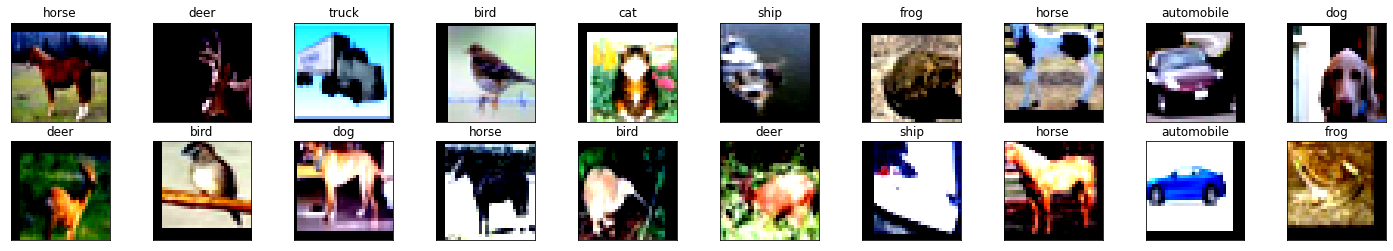

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
 
# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
 
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
 
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

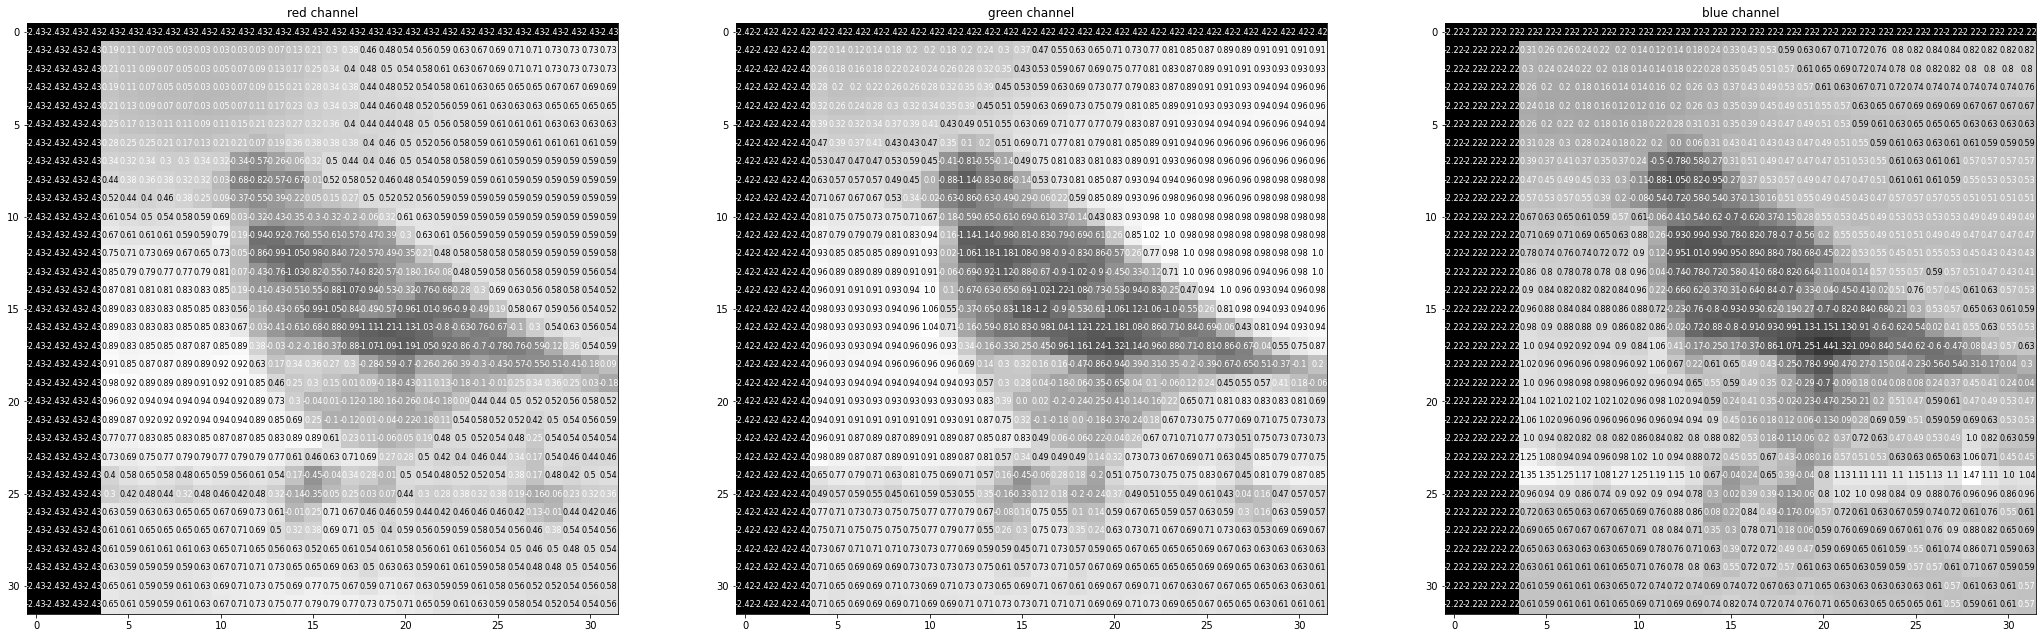

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']
 
fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1, 3, idx + 1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5  
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y] !=0 else 0
      ax.annotate(str(val), xy=(y,x),
      horizontalalignment='center',
      verticalalignment='center', size=8,
      color='white' if img[x][y]<thresh else 'black')

In [ ]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
 
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
 
    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out
 
class BottleNeck(nn.Module):
  expansion = 4
 
  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)
 
    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )
 
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out
 
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64
 
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)
 
  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion      
    return nn.Sequential(*layers)
 
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out
 
ResNet18 = ResNet(BasicBlock, [2,2,2,2])
#ResNet34 = ResNet(BasicBlock, [3,4,6,3])
#ResNet50 = ResNet(BottleNeck, [3,4,6,3])
#ResNet101 = ResNet(BottleNeck, [3,4,23,3])
#ResNet152 = ResNet(BottleNeck, [3,8,36,3])
 
print(ResNet18)
 
if train_on_gpu:
  ResNet18 = torch.nn.DataParallel(ResNet18)
  cudnn.benchmark = True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
 
# specify optimizer
optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [ ]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss
 
for epoch in range(1, n_epochs+1):
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0
    
  ###################
  # train the model #
  ###################
  ResNet18.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = ResNet18(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update training loss
    train_loss += loss.item()*data.size(0)
        
  ######################    
  # validate the model #
  ######################
  ResNet18.eval()
  for batch_idx, (data, target) in enumerate(valid_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = ResNet18(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average validation loss 
    valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
        
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))
    
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    torch.save(ResNet18.state_dict(), 'ResNet18.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.676269 	Validation Loss: 1.336527
Validation loss decreased (inf --> 1.336527).  Saving model ...
Epoch: 2 	Training Loss: 1.186514 	Validation Loss: 1.037701
Validation loss decreased (1.336527 --> 1.037701).  Saving model ...
Epoch: 3 	Training Loss: 0.923902 	Validation Loss: 0.844295
Validation loss decreased (1.037701 --> 0.844295).  Saving model ...
Epoch: 4 	Training Loss: 0.760452 	Validation Loss: 0.711960
Validation loss decreased (0.844295 --> 0.711960).  Saving model ...
Epoch: 5 	Training Loss: 0.648668 	Validation Loss: 0.673149
Validation loss decreased (0.711960 --> 0.673149).  Saving model ...
Epoch: 6 	Training Loss: 0.575047 	Validation Loss: 0.592062
Validation loss decreased (0.673149 --> 0.592062).  Saving model ...
Epoch: 7 	Training Loss: 0.520663 	Validation Loss: 0.541563
Validation loss decreased (0.592062 --> 0.541563).  Saving model ...
Epoch: 8 	Training Loss: 0.479519 	Validation Loss: 0.479718
Validation loss decreased (0.54156

In [ ]:
ResNet18.load_state_dict(torch.load('ResNet18.pt'))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
 
ResNet18.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = ResNet18(data)
  # calculate the batch loss
  loss = criterion(output, target)
  # update test loss 
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)    
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
 
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
 
for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
 
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.451142

Test Accuracy of airplane: 88% (885/1000)
Test Accuracy of automobile: 96% (968/1000)
Test Accuracy of  bird: 76% (767/1000)
Test Accuracy of   cat: 65% (650/1000)
Test Accuracy of  deer: 84% (843/1000)
Test Accuracy of   dog: 88% (880/1000)
Test Accuracy of  frog: 82% (825/1000)
Test Accuracy of horse: 88% (886/1000)
Test Accuracy of  ship: 92% (926/1000)
Test Accuracy of truck: 86% (864/1000)

Test Accuracy (Overall): 84% (8494/10000)


In [ ]:
print("Yahh Done!")

Yahh Done!
